<h1>Training of model | Image restoration</h1>
<hr/>

In [1]:
import numpy as np
import torch
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
from torch_utils import AverageMeter
from architecture import REDNet20, REDNet10, AE, SimpleCNN
from dataset import ImageRestorationDataset, extract_and_random_crop
from main import CreateLoaders
import config
from torchvision.utils import save_image
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_decoded_image(img,name):
    save_image(img,name)
    

torch.cuda.memory.empty_cache()


<h4>Create data loaders</h4>

In [2]:
dataset = ImageRestorationDataset('data')
pictures = []
full_dloader, train_dloader, val_dloader = CreateLoaders()
print(train_dloader.dataset[2][1].shape)
print(train_dloader.dataset[2][0].shape)

torch.Size([3, 100, 100])
torch.Size([4, 100, 100])


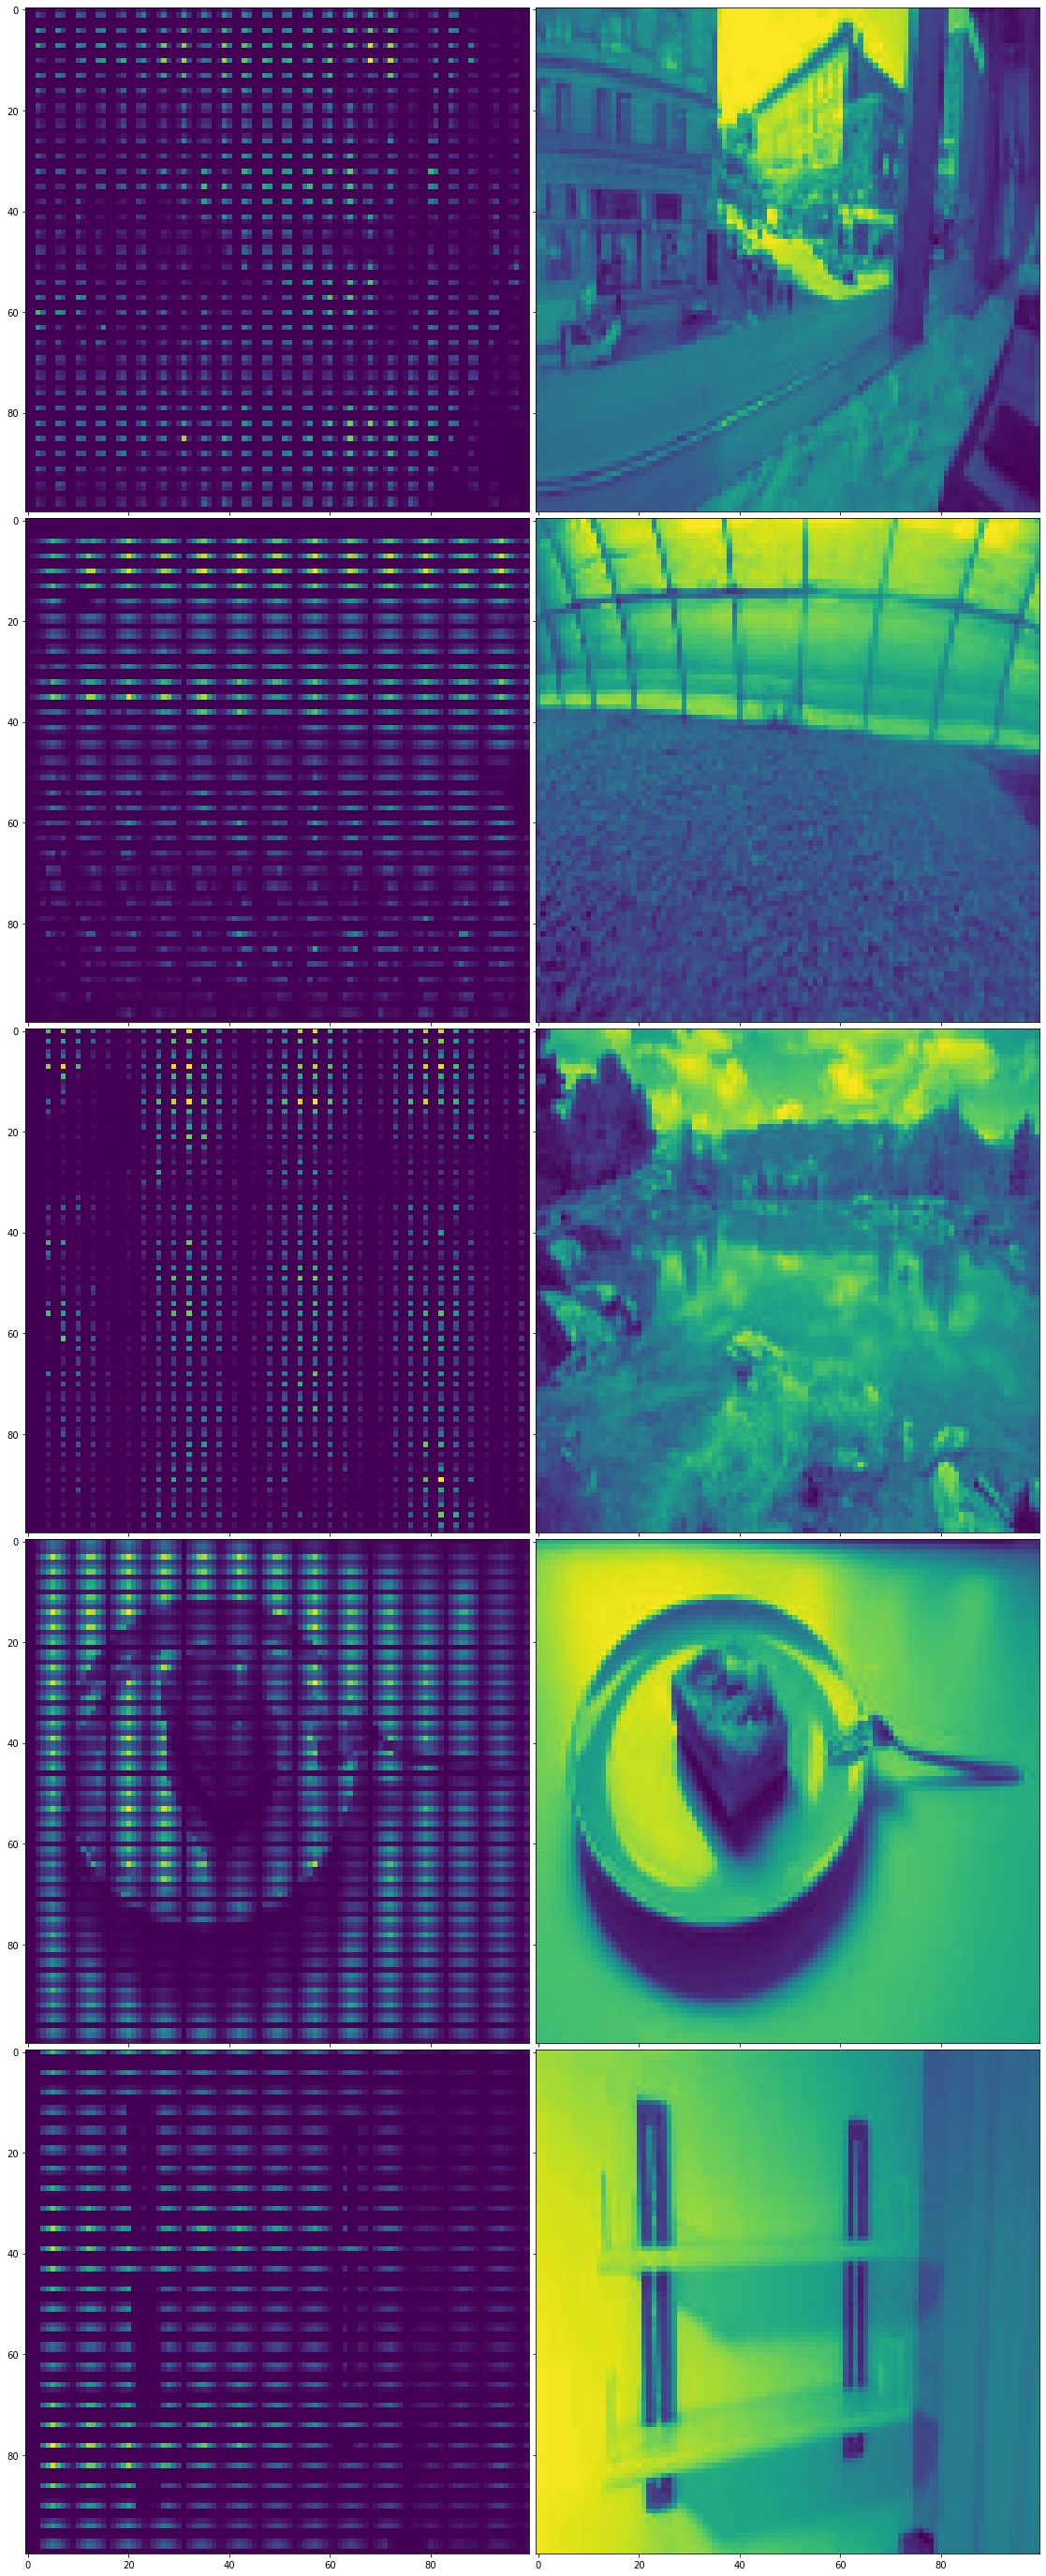

In [3]:
pics = []
transformation = transforms.ToPILImage()
for i,data in enumerate(train_dloader):
    if i == 5:
        break
    real,cropped = data
    pics.append(transformation(real[i][1]))
    pics.append(transformation(cropped[i][1]))

            


fig = plt.figure(figsize=(20, 50))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(5, 2),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, pics):
    ax.imshow(im)
plt.show()

<hr/>

<h3>Training the model</h3>

In [3]:
class AE(nn.Module):

    def __init__(self, neurons: int = 256,
                 kernel_size: int = 7):

        super(AE, self).__init__()
        self.neurons = neurons
        self.encoder = nn.Sequential(
            nn.Conv2d(4, self.neurons, kernel_size=kernel_size, stride=1),
            nn.ReLU(True),
            nn.Conv2d(self.neurons, self.neurons, kernel_size=kernel_size, stride=1),
            nn.ReLU(True),
            nn.Conv2d(self.neurons, self.neurons, kernel_size=kernel_size, stride=1),
            nn.ReLU(True),
            nn.Conv2d(self.neurons, self.neurons, kernel_size=kernel_size, stride=1),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.neurons, self.neurons, kernel_size=kernel_size, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(self.neurons, self.neurons, kernel_size=kernel_size, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(self.neurons, self.neurons, kernel_size=kernel_size, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(self.neurons, 3, kernel_size=kernel_size, stride=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [45]:
network = SimpleCNN(n_in_channels=4, n_hidden_layers=5, n_kernels=16, kernel_size=7)

with torch.no_grad():
    print(network(train_dloader.dataset[2][0].unsqueeze(0)).shape)

network = network.to(device)
network

torch.Size([1, 3, 100, 100])


SimpleCNN(
  (hidden_layers): Sequential(
    (0): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_layers): Sequential(
    (0): Upsample(scale_factor=1.0, mode=nearest)
    (1): ConvTranspose2d(256, 128, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32

In [46]:
# try:
#     network.load_state_dict(torch.load('simplecnn_model_state_100epoch.pt'))
# except FileNotFoundError:
#     pass

try:
    os.makedirs('output/alts')
    os.makedirs('output/results')
except:
	pass



def Train(model, loader, optimizer, epochs=config.EPOCHS):
    running_loss_tensorboard = 0.0
    for epoch in range(epochs):
        epoch_losses = AverageMeter(name="Meter",length=10)
        
        with tqdm(total=(len(loader.dataset)-len(loader.dataset)%config.BATCH_SIZE)) as _tqdm:
            _tqdm.set_description('epoch: {}/{}'.format(epoch + 1, epochs))
            for data in loader:
                inputs, originals = data
                
                labels = originals.to(device)
                inputs = inputs.to(device)
                optimizer.zero_grad()
                preds = model(inputs).to(device)
                loss = criterion(preds, labels)
                epoch_losses.update(loss.item())
                running_loss_tensorboard += loss.item()
                running_loss_tensorboard = 0.0
                loss.backward()
                optimizer.step()
                _tqdm.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
                _tqdm.update(len(inputs))
        
        save_decoded_image(labels.cpu().data,f'output/alts/cropped_epoch{epoch}.jpg')
        save_decoded_image(preds.cpu().data, f'output/alts/recon_epoch{epoch}.jpg')
    torch.save(model.state_dict(), f'model_state_{epochs}epoch.pt')
    torch.save(model,f'saved_model_{epochs}epoch.pt')
    
        

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0005)
training = Train(network, full_dloader, optimizer, epochs=50)
training

epoch: 1/50: : 29410it [04:13, 116.19it/s, loss=0.060957]                         
epoch: 2/50: : 29410it [04:09, 117.85it/s, loss=0.059869]                         
epoch: 3/50: : 29410it [04:09, 117.76it/s, loss=0.059439]                         
epoch: 4/50: : 29410it [04:12, 116.50it/s, loss=0.059201]                         
epoch: 5/50: : 29410it [04:10, 117.59it/s, loss=0.059048]                         
epoch: 6/50: : 29410it [04:09, 117.74it/s, loss=0.058987]                         
epoch: 7/50: : 29410it [04:09, 117.97it/s, loss=0.058889]                         
epoch: 8/50: : 29410it [04:09, 117.78it/s, loss=0.058768]                         
epoch: 9/50: : 29410it [04:09, 117.74it/s, loss=0.058708]                         
epoch: 10/50: : 29410it [04:09, 117.84it/s, loss=0.058904]                         
epoch: 11/50: : 29410it [04:09, 117.90it/s, loss=0.058638]                         
epoch: 12/50: : 29410it [04:09, 117.88it/s, loss=0.058629]                         
e

<hr/>


<H3>Reconstruct test images</H3>


In [65]:
import pickle as pkl
import torchvision.transforms.functional as tf
import numpy as np
from MaskImage import MaskedImage
from PIL import Image

try:
    os.makedirs('output/test_outs')
except:
	pass

preds = []

with open('inputs.pkl', 'rb') as f:
    file = pkl.load(f)
    print(file.keys())
    network.eval()
    for e, (img_cropped, known_array, offset, spacing) in enumerate(zip(file['input_arrays'],
                                                       file['known_arrays'],
                                                       file['offsets'],
                                                       file['spacings'])):
        input_image = np.concatenate((img_cropped,
                                      np.expand_dims(known_array[0, :, :], 0)), 0)
        input_image = tf.to_tensor(input_image.transpose((1, 2, 0))).unsqueeze(0).to(device)
        output_image = network(input_image).squeeze(0)
        save_decoded_image(output_image.cpu().data,f'output/test_outs/reconstruct_{e}.jpg')
        # arr = output_image.type(torch.DoubleTensor).cpu().data.numpy()

        arr = Image.open(f'output/test_outs/reconstruct_{e}.jpg')
        image_array, known_array, target_array = MaskedImage(np.asarray(arr).astype(np.uint8), offset, spacing)
        preds.append(target_array)

with open('predictions.pkl', 'wb') as f:
    pkl.dump(preds, f)

dict_keys(['input_arrays', 'known_arrays', 'offsets', 'spacings', 'sample_ids'])


C:\Users\bollo\anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [68]:
preds[0][2000:2200]

array([120, 120, 119, 117, 120, 122, 134, 138, 149, 151, 151, 146, 143,
       140, 136, 129, 127, 134, 141, 153, 155, 155, 152, 145, 150, 159,
       158, 159, 156, 156, 156, 158, 158, 157, 156, 154, 150, 150, 147,
       150, 156, 158, 157, 156, 151, 149, 147, 144, 104, 104, 103,  99,
        99, 103, 112, 118, 120, 118, 116, 116, 117, 119, 121, 123, 134,
       133, 131, 131, 129, 128, 129, 129, 129, 129, 130, 130, 130, 132,
       133, 133, 138, 131, 126, 123, 126, 127, 124, 120, 122, 123, 125,
       124, 122, 123, 125, 128, 135, 135, 139, 144, 148, 148, 146, 142,
       144, 142, 137, 130, 125, 126, 133, 140, 150, 150, 151, 152, 148,
       141, 142, 145, 156, 155, 156, 154, 152, 151, 152, 152, 154, 154,
       153, 151, 150, 150, 148, 149, 148, 150, 154, 155, 158, 156, 156,
       155, 152, 150, 148, 145, 102, 105, 105, 104, 104, 106, 112, 116,
       118, 116, 113, 112, 112, 114, 116, 117, 124, 123, 122, 120, 119,
       120, 119, 120, 128, 128, 129, 130, 132, 133, 134, 135, 13

In [33]:
from glob import glob
from PIL import Image
import pickle as pkl

preds = []

for file in glob('./output/test_outs/*.jpg'):
    p = Image.open(file)
    arr = np.asarray(p).transpose((2, 0, 1))
    preds.append(arr)

with open('predictions.pkl', 'wb') as f:
    pkl.dump(preds, f)

In [16]:
import pickle as pkl
import numpy as np

with open('inputs.pkl', 'rb') as f:
    file = pkl.load(f)
    pixel_values = file['known_arrays']

idcs = np.array(np.where(pixel_values[0][0] == 1))